In [31]:
import pandas as pd
from utils.data_processing import EyeTrackingProcessor, GazeMetricsProcessor, MouseMetricsProcessor
import matplotlib.pyplot as plt

from collections import defaultdict
import numpy as np
import os
from tqdm import tqdm
from typing import Union, Dict, Tuple
from pathlib import Path

In [23]:
data_path = "/store/kruu/eye_tracking/atco_hungary"
features = ['Recording timestamp [ms]', 'Gaze point X [DACS px]', 'Gaze point Y [DACS px]', 'Mouse position X [DACS px]', 'Mouse position Y [DACS px]', 'Event']
interpolate_cols = ['Gaze point X [DACS px]', 'Gaze point Y [DACS px]', 'Mouse position X [DACS px]', 'Mouse position Y [DACS px]', "Blink"]
fill_columns = ['Gaze point X [DACS px]', 'Gaze point Y [DACS px]', 'Mouse position X [DACS px]', 'Mouse position Y [DACS px]']

def load_and_process(
    data_path: Union[str, Path],
    columns: list[str],
    interpolate_cols: list[str],
    fill_cols: list[str],
    time_resampling: bool = True,            # Fixed time step resampling for JCAFNET 
    fixed_window_ms: int | None = 3000,      # set to None to keep old behavior (chuning per task)
    window_step_ms: int | None = None,       # hop size (None = same as window)
    min_task_presence: float = 0.5,          # majority threshold
) -> pd.DataFrame:
    
    files_list = os.listdir(data_path)
    files_list = [os.path.join(data_path, file) for file in files_list if file.endswith(".tsv")]
    
    processor = EyeTrackingProcessor()
    all_data, atco_task_map = processor.load_data(files_list)

    ###### Chunking Strategy ######
    if fixed_window_ms is not None:
        # Chunk every XX seconds
        chunks = processor.get_fixed_window_chunks(
            all_data,
            features=columns,
            window_ms=fixed_window_ms,
            step_ms=window_step_ms,
            min_presence=min_task_presence,
        )
    else:
        # Chunk per task
        chunks = processor.get_features(all_data, columns)

    # Blink detection
    chunks, blinks = processor.detect_blinks(chunks)
    
    # Optional time-step resampling (e.g., XX ms grid for the sequential analsysis of the JCAFNET)
    if time_resampling: 
        resampled_chunks_time = processor.resample_task_chunks(chunks, interpolate_cols, mode="time", param=10)

        for task_id, chunk in resampled_chunks_time.items():
            # Transform interpolated Blink back to boolean and fill other features
            resampled_chunks_time[task_id].Blink = (resampled_chunks_time[task_id].Blink > 0.5)
            for col in fill_cols:
                resampled_chunks_time[task_id][col] = resampled_chunks_time[task_id][col].ffill().bfill()
            
        return resampled_chunks_time, blinks, atco_task_map

    return chunks, blinks, atco_task_map

chunks_fixed_len, blinks_fixed_len, task_map_fixed_len = load_and_process(
    data_path=data_path,
    columns=features,              # include the timestamp col here
    interpolate_cols=interpolate_cols,
    fill_cols=fill_columns,
    time_resampling=False,
    fixed_window_ms=3000,          # 3s windows
    window_step_ms=500,           # no overlap = None
    min_task_presence=0.5 
)

chunks_task, blinks_task, task_map_task = load_and_process(
    data_path=data_path,
    columns=features,              # include the timestamp col here
    interpolate_cols=interpolate_cols,
    fill_cols=fill_columns,
    time_resampling=False,
    fixed_window_ms=None,          # 3s windows
    window_step_ms=None,           # no overlap = None
)

In [37]:
task_map_fixed_len
# print(task_map_task)

{'Aircraft requests': 'Task 0',
 'Conflict resolution': 'Task 1',
 'Coordination response': 'Task 2',
 'QoS': 'Task 3',
 'Return to route': 'Task 4',
 'assume': 'Task 5',
 'transfer': 'Task 6'}

In [29]:
from collections import Counter

# Task 2 is always too brief to be associated with a task

print("Number of task occurences for fixed length window: ")
task_window_counts = Counter(int(df["Task_id"].iloc[0]) for df in chunks_fixed_len.values())
# Pretty print
for task_id in sorted(task_window_counts):
    print(f"Task {task_id}: {task_window_counts[task_id]} windows")
    
print("\n")

print("Number of task occurences in the dataset: ")
task_window_counts = Counter(int(df["Task_id"].iloc[0]) for df in chunks_task.values())
# Pretty print
for task_id in sorted(task_window_counts):
    print(f"Task {task_id}: {task_window_counts[task_id]} windows")

Number of task occurences for fixed length window: 
Task 0: 312 windows
Task 1: 2706 windows
Task 3: 108 windows
Task 4: 3198 windows
Task 5: 1740 windows
Task 6: 2676 windows


Number of task occurences in the dataset: 
Task 0: 12 windows
Task 1: 60 windows
Task 2: 6 windows
Task 3: 6 windows
Task 4: 78 windows
Task 5: 102 windows
Task 6: 66 windows


In [35]:
durations_by_task = defaultdict(list)

for df in chunks_task.values():
    task_id = int(df["Task_id"].iloc[0])

    ts_col = "Recording timestamp [ms]"
    ts = df[ts_col].astype(float)
    dur_ms = float(ts.max() - ts.min())

    durations_by_task[task_id].append(dur_ms)

avg_ms_by_task = {task: float(np.mean(durs)) for task, durs in durations_by_task.items()}

for task_id in sorted(avg_ms_by_task):
    print(f"Task {task_id}: {avg_ms_by_task[task_id]:.1f} ms ({avg_ms_by_task[task_id]/1000:.3f} s)")

Task 0: 12871.0 ms (12.871 s)
Task 1: 24374.9 ms (24.375 s)
Task 2: 28127.0 ms (28.127 s)
Task 3: 8991.0 ms (8.991 s)
Task 4: 20467.5 ms (20.468 s)
Task 5: 9096.8 ms (9.097 s)
Task 6: 20743.6 ms (20.744 s)


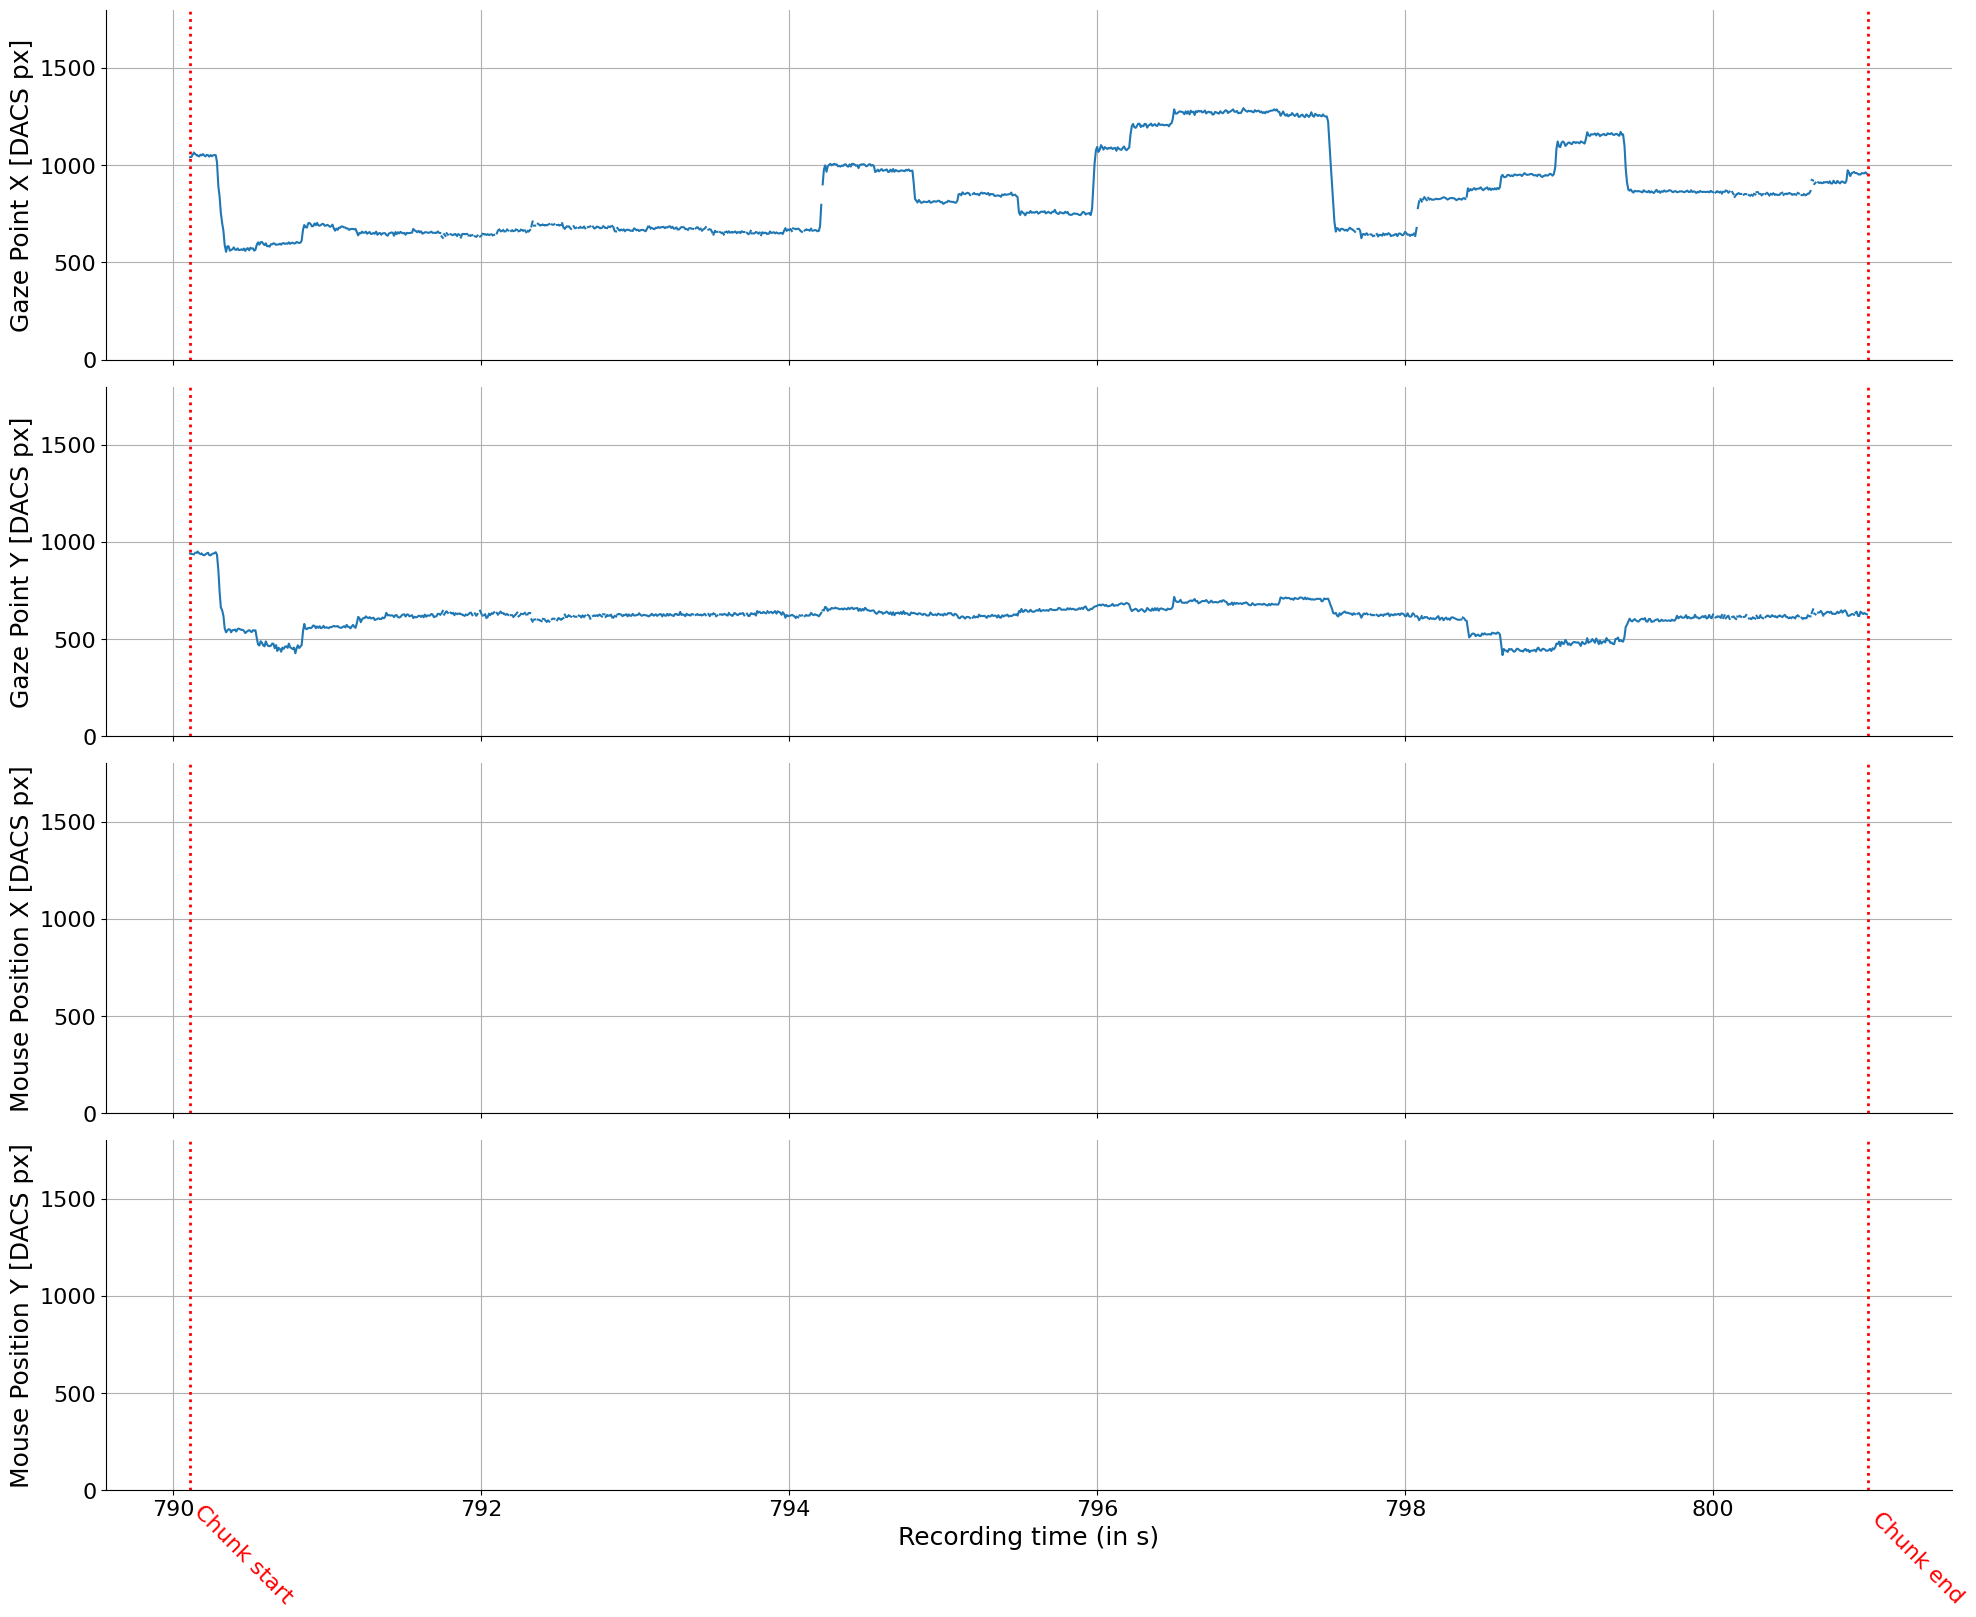

In [40]:
id_task = "0_0_0"
task_plot = chunks_task[id_task]

fig, axs = plt.subplots(4, 1, figsize=(20, 16), sharex=True)
# Convert timestamps to seconds
timestamps_sec = task_plot["Recording timestamp [ms]"] / 1e3
start_time_sec = task_plot.iloc[0]["Recording timestamp [ms]"] / 1e3
end_time_sec = task_plot.iloc[-1]["Recording timestamp [ms]"] / 1e3

# Titles for each subplot
titles = ['Gaze Point X [DACS px]', 'Gaze Point Y [DACS px]', 'Mouse Position X [DACS px]', 'Mouse Position Y [DACS px]']
data_columns = ['Gaze point X [DACS px]', 'Gaze point Y [DACS px]', 'Mouse position X [DACS px]', 'Mouse position Y [DACS px]']

# Plot each subplot
for ax, title, col in zip(axs, titles, data_columns):
    ax.plot(timestamps_sec, task_plot[col], label=title)
    ax.axvline(x=start_time_sec, color='red', linestyle=':', linewidth=2)
    ax.axvline(x=end_time_sec, color='red', linestyle=':', linewidth=2)
    ax.set_ylim(0, 1800)
    ax.set_ylabel(title)
    ax.grid(True)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

# Add labels directly to vertical lines on the top subplot only
axs[-1].text(start_time_sec, -600, 'Chunk start', color='red', rotation=-45, verticalalignment='bottom', fontsize = 16)
axs[-1].text(end_time_sec, -600, 'Chunk end', color='red', rotation=-45, verticalalignment='bottom', fontsize = 16)

# X-axis label on the last subplot
axs[-1].set_xlabel('Recording time (in s)', fontsize = 18)

for ax in axs:
    ax.tick_params(axis='both', labelsize=16)
    ax.set_ylabel(ax.get_ylabel(), fontsize=18)

plt.tight_layout()
plt.show()